# Counting mode
The goal of this script is to try to apply counting mode to dark field region of acquired CBEDs to reduce image noise and get a better quantitative matching between simulation and experiment.
<br>Problems to think about:
<br>1. How to find the region that counting mask can be applied? Automatic finding is preferred, otherwise can be hard coded as an input parameter.
<br>2. How to convert electron into intensity counts.

In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

import imutils
import cv2

## Apply counting mode on a single frame
<br>Input: image, SizeThreshold, IntThreshold.
<br>Connected component with intensity > IntThreshold and size < SizeThreshold is considered to be a single electron event.
<br>Averaged intensity from all SE events is used as Ise, and the intensity is applied to COM of each event.

In [23]:
path = '/srv/home/chenyu/DEbackup/022119/S5/npy/'
sample = np.load(path+'S5_10000.npy')
# sample[sample<0] = 0

(-0.5, 199.5, 199.5, -0.5)

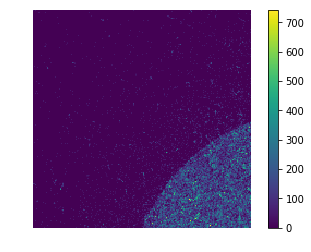

In [50]:
plt.imshow(frame_counting[0:200,0:200])
plt.colorbar()
plt.axis('off')

(-0.5, 199.5, 199.5, -0.5)

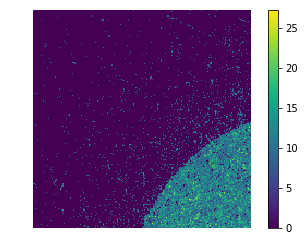

In [59]:
plt.imshow(np.sqrt(frame_counting[0:200,0:200]))
plt.colorbar()
plt.axis('off')

In [58]:
from skimage import measure
from skimage import filters
import time

path = '/srv/home/chenyu/DEbackup/022119/S5/npy/'
sample = np.load(path+'S5_10000.npy')

# set up timer
start = time.time()

frame = sample
frame_linear = frame
frame_binary = np.heaviside(frame-30,1)
frame_counting = np.zeros(frame_binary.shape)
all_labels = measure.label(frame_binary)
blob_labels = measure.label(frame_binary, background=0)

# Determine number of total events
ncomponents = np.amax(all_labels)
SizeThreshold = 3    # maximum size for a single electron event in pixels
SEnumber = 0
SEint = 0
SEint_list = []
SEsize_list = []

# start = time.time()

for i in range(ncomponents):
    component_size = np.where(all_labels == i)[0].shape
    if component_size[0] < SizeThreshold:
        component_idx = np.where(all_labels == i)
        SEsize_list.append(component_size[0])
        
        # append total intensity of this SE event to the total
        int_list = frame[component_idx[0],component_idx[1]]
        SEint = SEint + np.sum(int_list)
        SEnumber = SEnumber + 1
        SEint_list.append(np.sum(int_list))
        
        # calculate COM for this event and assign that pixel to 1
        cor_row = np.average(component_idx[0],weights=int_list)
        cor_col = np.average(component_idx[1],weights=int_list)
        frame_counting[int(cor_row), int(cor_col)] = 1         # set COM pixel in counting image to 1
        frame_linear[component_idx[0],component_idx[1]] = 0    # set these pixels in linear image to zero
        
# end = time.time()

# Deal with background, which is the most frequent number in all_labels, then set it to zero
(values,counts) = np.unique(all_labels,return_counts=True)
ind = np.argmax(counts)
component_idx = np.where(all_labels == ind)
frame_linear[component_idx[0],component_idx[1]] = 0

# Combine linear part with counting part
print("Totally " + str(SEnumber) + " SE events.")
SEint = SEint / SEnumber
print("Average intensity: " + str(SEint))
frame_counting = frame_counting * SEint
frame_counting = frame_counting + frame_linear

end = time.time()
print("Time elapsed: " + str(end-start) + "seconds.")

Totally 4098 SE events.
Average intensity: 69.43268751249215
Time elapsed: 7.5711305141448975seconds.


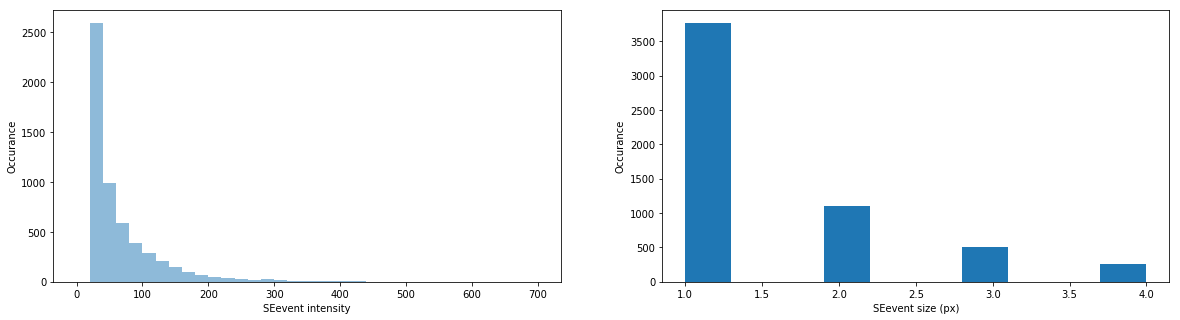

In [47]:
# Plot histogram of intensity
fig = plt.figure(figsize=(20,5))
fig.add_subplot(1,2,1)
bins = np.arange(0, np.amax(np.asarray(SEint_list)), 20) # fixed bin size
plt.hist(np.asarray(SEint_list), bins=bins, alpha=0.5)
# plt.title('SEevent intensity')
plt.xlabel('SEevent intensity')
plt.ylabel('Occurance')

fig.add_subplot(1,2,2)
plt.hist(np.asarray(SEsize_list))
plt.xlabel('SEevent size (px)')
plt.ylabel('Occurance')
plt.show()

## Run counting mode for missing files

In [63]:
path_linear = '/srv/home/chenyu/DEbackup/022119/S5/npy/'
path_counting = '/srv/home/chenyu/DEbackup/022119/S5/npy_counting_5px_20counts/'
filelist = glob.glob1(path_linear,"*.npy")
for ifile in range(len(filelist)):
    if not os.path.isfile(path_counting+filelist[ifile]):
        print(filelist[ifile])
        frame = counting_frame(path_linear + filelist[ifile])
        np.save(path_counting + filelist[ifile],frame)

S5_11871.npy
S5_18785.npy
S5_15013.npy
S5_02832.npy
S5_21113.npy
S5_18185.npy
S5_14909.npy
S5_21872.npy
S5_04131.npy
S5_05660.npy
S5_13858.npy
S5_06987.npy
S5_14317.npy
S5_20299.npy
S5_09860.npy
S5_10065.npy
S5_09319.npy
S5_13805.npy
S5_22335.npy
S5_16946.npy
S5_17998.npy
S5_13017.npy
S5_04246.npy
S5_19041.npy
S5_07193.npy
S5_12206.npy
S5_07702.npy
S5_18042.npy
S5_11003.npy
S5_07545.npy


In [61]:
def counting_frame(filename):

    frame = np.load(filename)
    frame_linear = frame
    frame_binary = np.heaviside(frame-20,1)
    frame_counting = np.zeros(frame_binary.shape)
    all_labels = measure.label(frame_binary)
    blob_labels = measure.label(frame_binary, background=0)


    # Determine number of total events
    ncomponents = np.amax(all_labels)
    SizeThreshold = 5    # maximum size for a single electron event in pixels
    SEnumber = 0
    SEint = 0

    for i in range(ncomponents):
        component_size = np.where(all_labels == i)[0].shape
        if component_size[0] < SizeThreshold:
            component_idx = np.where(all_labels == i)

            # append total intensity of this SE event to the total
            int_list = frame[component_idx[0],component_idx[1]]
            SEint = SEint + np.sum(int_list)
            SEnumber = SEnumber + 1

            # calculate COM for this event and assign that pixel to 1
            cor_row = np.average(component_idx[0],weights=int_list)
            cor_col = np.average(component_idx[1],weights=int_list)
            frame_counting[int(cor_row), int(cor_col)] = 1
            frame_linear[component_idx[0],component_idx[1]] = 0    # set these pixels in linear image to zero

    # Deal with background, which is the most frequent number in all_labels, then set it to zero
    (values,counts) = np.unique(all_labels,return_counts=True)
    ind = np.argmax(counts)
    component_idx = np.where(all_labels == ind)
    frame_linear[component_idx[0],component_idx[1]] = 0

    # Combine linear part with counting part
    SEint = SEint / SEnumber
    frame_counting = frame_counting * SEint
    frame_counting = frame_counting + frame_linear

    return(frame_counting)

## Run counting mode for the whole series

In [62]:
# Apply multiple threads on head node
# Not sure why this parallel procedure doesn't work for computing node x scratch disk

from joblib import Parallel, delayed
import multiprocessing

folder = '/srv/home/chenyu/DEbackup/022119/S5/npy/'
savepath = '/srv/home/chenyu/DEbackup/022119/S5/npy_counting_5px_20counts/'

num_cores = multiprocessing.cpu_count()
num_files = len(glob.glob1(folder,"*.npy"))

# Total 40 cores availiable, use half to avoid impact other jobs
num_cores = 30
batch_size = num_files // num_cores
print(batch_size)
print("Total " + str(num_cores) + " cores for " + str(num_files) + " files.\n")
Parallel(n_jobs=num_cores)(delayed(counting)(folder, i*batch_size, (i+1)*batch_size-1, savepath) for i in range(num_cores))

750
Total 30 cores for 22500 files.



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [60]:
def counting(folder, start, end, savepath):
#     f = open("output.txt","a")
#     f.write("Now working on file # from " + str(start) + " to " + str(end) + "\n")
#     f.close()

    for ifile in range(start,end):
        filename = glob.glob1(folder,"*.npy")[ifile]
        # Add if condition here to confirm this file does not exist in output path
        frame = np.load(folder + filename)
        frame_linear = frame
        frame_binary = np.heaviside(frame-20,1)
        frame_counting = np.zeros(frame_binary.shape)
        all_labels = measure.label(frame_binary)
        blob_labels = measure.label(frame_binary, background=0)
        

        # Determine number of total events
        ncomponents = np.amax(all_labels)
        SizeThreshold = 5    # maximum size for a single electron event in pixels
        SEnumber = 0
        SEint = 0

        for i in range(ncomponents):
            component_size = np.where(all_labels == i)[0].shape
            if component_size[0] < SizeThreshold:
                component_idx = np.where(all_labels == i)

                # append total intensity of this SE event to the total
                int_list = frame[component_idx[0],component_idx[1]]
                SEint = SEint + np.sum(int_list)
                SEnumber = SEnumber + 1

                # calculate COM for this event and assign that pixel to 1
                cor_row = np.average(component_idx[0],weights=int_list)
                cor_col = np.average(component_idx[1],weights=int_list)
                frame_counting[int(cor_row), int(cor_col)] = 1
                frame_linear[component_idx[0],component_idx[1]] = 0    # set these pixels in linear image to zero

        # Deal with background, which is the most frequent number in all_labels, then set it to zero
        (values,counts) = np.unique(all_labels,return_counts=True)
        ind = np.argmax(counts)
        component_idx = np.where(all_labels == ind)
        frame_linear[component_idx[0],component_idx[1]] = 0

        # Combine linear part with counting part
        SEint = SEint / SEnumber
        frame_counting = frame_counting * SEint
        frame_counting = frame_counting + frame_linear
        
        np.save(savepath+filename, frame_counting)

## Make PACBED from counting mode frames

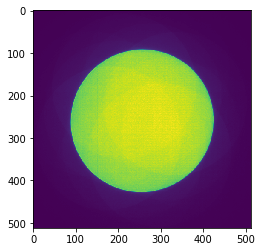

In [65]:
path_counting = '/srv/home/chenyu/DEbackup/022119/S5/npy_counting_5px_20counts/'
temp = np.load(path_counting + 'S5_10000.npy')
PACBED_counting = np.zeros(temp.shape)

filelist = glob.glob1(path_counting,"*.npy")
for ifile in range(len(filelist)):
    frame = np.load(path_counting + filelist[ifile])
    PACBED_counting = PACBED_counting + frame
    
PACBED_counting = PACBED_counting / (ifile + 1)
plt.imshow(PACBED_counting)

In [67]:
np.save('/srv/home/chenyu/DEbackup/022119/S5/PACBED_counting_5px_20counts.npy',PACBED_counting)

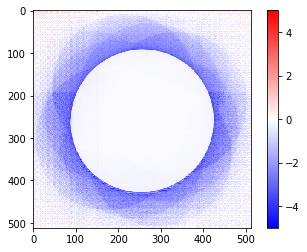

In [69]:
PACBED_counting = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED_counting_3px_20counts.npy')
plt.imshow(PACBED_counting - PACBED,cmap='bwr')
plt.clim([-5,5])
plt.colorbar()

(-0.5, 511.5, 511.5, -0.5)

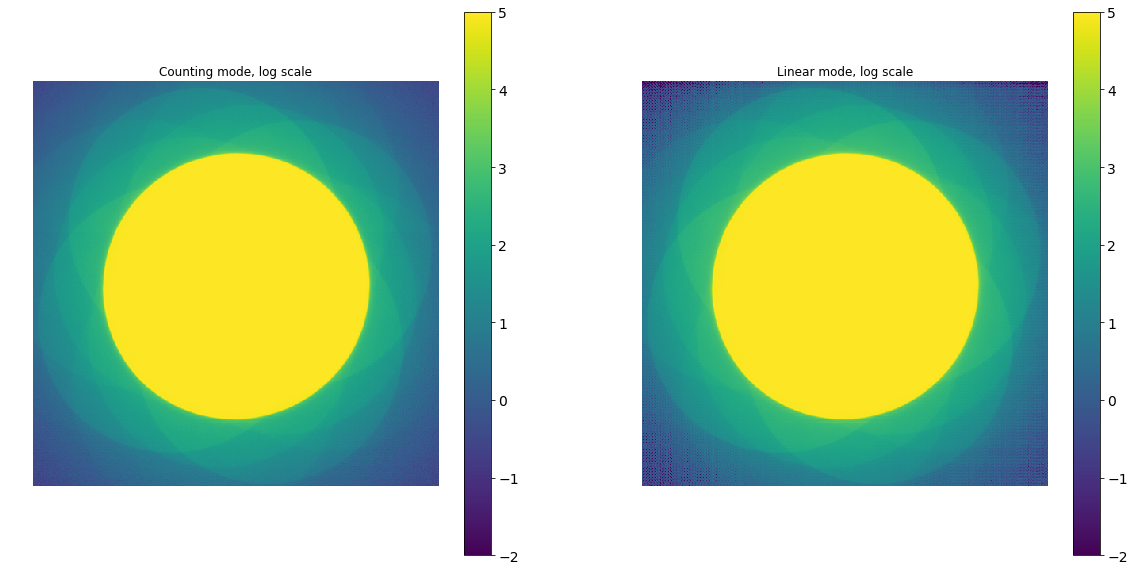

In [79]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1)
PACBED_counting = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED_counting_3px_20counts.npy')
plt.imshow(log(PACBED_counting))
plt.clim([-2,5])
plt.title('Counting mode, log scale')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

fig.add_subplot(1,2,2)
PACBED = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED.npy')
PACBED[PACBED<0] = np.amin(PACBED[PACBED>0])
plt.imshow(log(PACBED))
plt.clim([-2,5])
plt.title('Linear mode, log scale')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

## Generate a mask for counting mode
Use counting mode outside the mask (mask=0) and use linear mode inside the mask (mask=1)

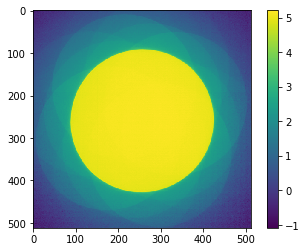

In [83]:
plt.imshow(log(PACBED_counting))
plt.colorbar()

(-0.5, 511.5, 511.5, -0.5)

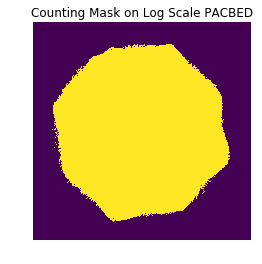

In [84]:
mask = np.heaviside(log(PACBED_counting)-2.0,1)
mask[isnan(mask)] = 0
plt.imshow(mask*log(PACBED_counting))
plt.imshow(mask)
plt.title('Counting Mask on Log Scale PACBED')
plt.axis('off')

## Counting with mask for single frame

Totally 3151 SE events.
Average intensity: 37.78989471151427
Time elapsed: 7.5200722217559814seconds.


Text(0.5, 1.0, 'Counting - Linear')

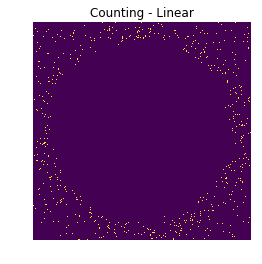

In [142]:
from skimage import measure
from skimage import filters
import time

path = '/srv/home/chenyu/DEbackup/022119/S5/npy/'
sample = np.load(path+'S5_10000.npy')

# set up timer
start = time.time()

frame = sample
frame_linear = frame
frame_binary = np.heaviside(frame-20,1)
frame_counting = np.zeros(frame_binary.shape)
all_labels = measure.label(frame_binary)
blob_labels = measure.label(frame_binary, background=0)

# Determine number of total events
ncomponents = np.amax(all_labels)
SizeThreshold = 3    # maximum size for a single electron event in pixels
SEnumber = 0
SEint = 0

# start = time.time()

for i in range(ncomponents):
    component_size = np.where(all_labels == i)[0].shape
    if component_size[0] < SizeThreshold:
        component_idx = np.where(all_labels == i)
        
        if np.sum(mask[component_idx])==0:
        # append total intensity of this SE event to the total
            int_list = frame[component_idx[0],component_idx[1]]
            SEint = SEint + np.sum(int_list)
            SEnumber = SEnumber + 1

            # calculate COM for this event and assign that pixel to 1
            cor_row = np.average(component_idx[0],weights=int_list)
            cor_col = np.average(component_idx[1],weights=int_list)
            frame_counting[int(cor_row), int(cor_col)] = 1         # set COM pixel in counting image to 1
            frame_linear[component_idx[0],component_idx[1]] = 0    # set these pixels in linear image to zero
        
# end = time.time()

# Deal with background, which is the most frequent number in all_labels, then set it to zero
(values,counts) = np.unique(all_labels,return_counts=True)
ind = np.argmax(counts)
component_idx = np.where(all_labels == ind)
frame_linear[component_idx[0],component_idx[1]] = 0

# Combine linear part with counting part
print("Totally " + str(SEnumber) + " SE events.")
SEint = SEint / SEnumber
print("Average intensity: " + str(SEint))
frame_counting = frame_counting * SEint
frame_counting = frame_counting + frame_linear

end = time.time()
print("Time elapsed: " + str(end-start) + "seconds.")

# Should show no difference between linear mode and counting mode inside the mask
plt.imshow(frame_counting - sample)
plt.axis('off')
plt.title('Counting - Linear')

## Counting with mask for whole series

In [85]:
# Apply multiple threads on head node
# Not sure why this parallel procedure doesn't work for computing node x scratch disk

from joblib import Parallel, delayed
import multiprocessing

folder = '/srv/home/chenyu/DEbackup/022119/S5/npy/'
savepath = '/srv/home/chenyu/DEbackup/022119/S5/npy_counting_mask/'

num_cores = multiprocessing.cpu_count()
num_files = len(glob.glob1(folder,"*.npy"))

# Total 40 cores availiable, use half to avoid impact other jobs
num_cores = 30
batch_size = num_files // num_cores
print(batch_size)
print("Total " + str(num_cores) + " cores for " + str(num_files) + " files.\n")
Parallel(n_jobs=num_cores)(delayed(counting_mask)(folder, i*batch_size, (i+1)*batch_size-1, savepath) for i in range(num_cores))

750
Total 30 cores for 22500 files.



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [80]:
def counting_mask(folder, start, end, savepath):

    for ifile in range(start,end):
        filename = glob.glob1(folder,"*.npy")[ifile]
        # Add if condition here to confirm this file does not exist in output path
        frame = np.load(folder + filename)
        frame_linear = frame
        frame_binary = np.heaviside(frame-20,1)
        frame_counting = np.zeros(frame_binary.shape)
        all_labels = measure.label(frame_binary)
        blob_labels = measure.label(frame_binary, background=0)
        

        # Determine number of total events
        ncomponents = np.amax(all_labels)
        SizeThreshold = 5    # maximum size for a single electron event in pixels
        SEnumber = 0
        SEint = 0

        for i in range(ncomponents):
            component_size = np.where(all_labels == i)[0].shape
            if component_size[0] < SizeThreshold:
                component_idx = np.where(all_labels == i)
                
                if np.sum(mask[component_idx]==0):

                    # append total intensity of this SE event to the total
                    int_list = frame[component_idx[0],component_idx[1]]
                    SEint = SEint + np.sum(int_list)
                    SEnumber = SEnumber + 1

                    # calculate COM for this event and assign that pixel to 1
                    cor_row = np.average(component_idx[0],weights=int_list)
                    cor_col = np.average(component_idx[1],weights=int_list)
                    frame_counting[int(cor_row), int(cor_col)] = 1
                    frame_linear[component_idx[0],component_idx[1]] = 0    # set these pixels in linear image to zero

        # Deal with background, which is the most frequent number in all_labels, then set it to zero
        (values,counts) = np.unique(all_labels,return_counts=True)
        ind = np.argmax(counts)
        component_idx = np.where(all_labels == ind)
        frame_linear[component_idx[0],component_idx[1]] = 0

        # Combine linear part with counting part
        SEint = SEint / SEnumber
        frame_counting = frame_counting * SEint
        frame_counting = frame_counting + frame_linear
        
        np.save(savepath+filename, frame_counting)

In [136]:
np.save('/srv/home/chenyu/DEbackup/022119/S5/PACBED_counting_mask.npy',PACBED_counting_mask)

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


(-0.5, 511.5, 511.5, -0.5)

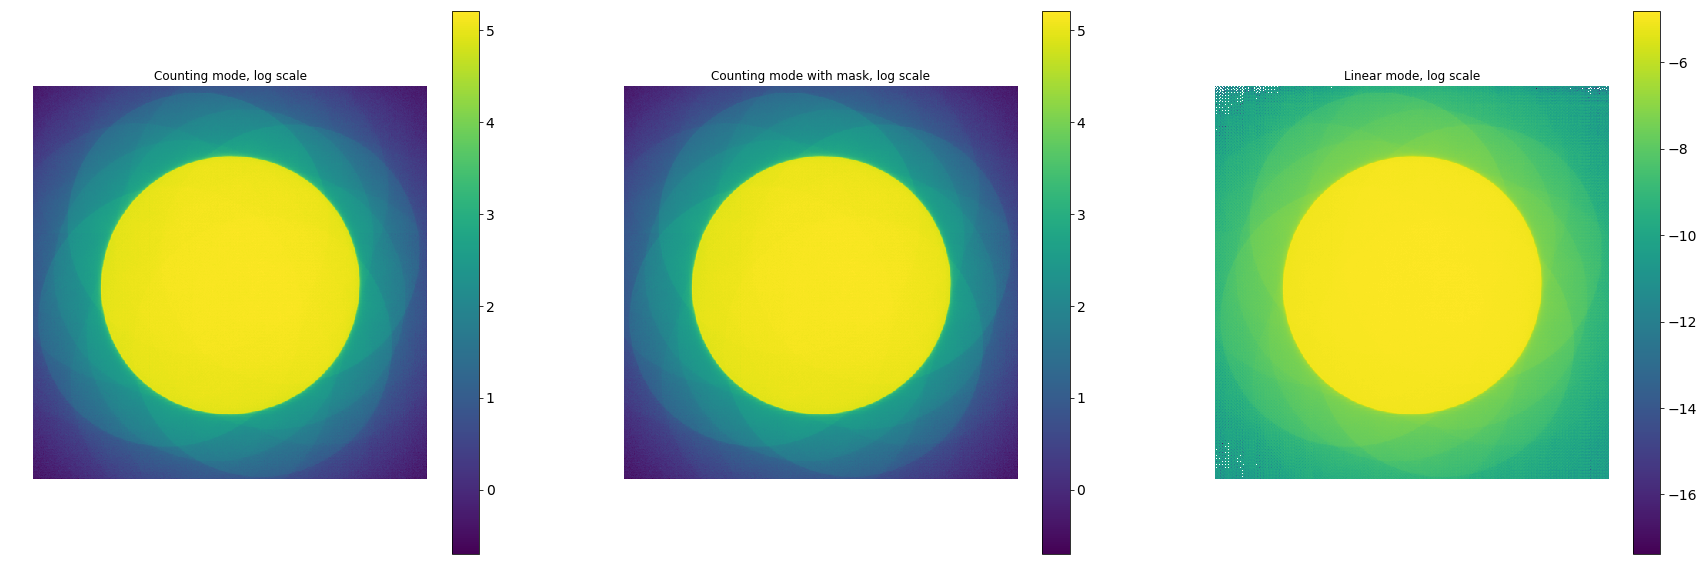

In [131]:
fig = plt.figure(figsize=(30,10))
fig.add_subplot(1,3,1)
PACBED_counting = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED_counting_3px_8counts.npy')
plt.imshow(log(PACBED_counting))
plt.title('Counting mode, log scale')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

fig.add_subplot(1,3,2)
PACBED_counting = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED_counting_mask.npy')
plt.imshow(log(PACBED_counting))
plt.title('Counting mode with mask, log scale')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

fig.add_subplot(1,3,3)
PACBED = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED.npy')
plt.imshow(log(PACBED/22500))
plt.title('Linear mode, log scale')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

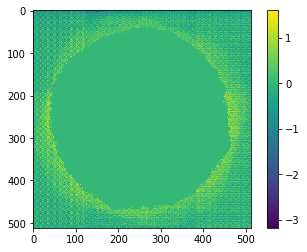

In [137]:
# Plot difference from applying a mask
PACBED_counting = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED_counting_3px_8counts.npy')
PACBED_counting_mask = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED_counting_mask.npy')
PACBED = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED.npy')


plt.imshow(PACBED - PACBED_counting_mask)
plt.colorbar()

## For further denoising with NLPCA, see Counting_NLPCA notebook

In [3]:
A = np.linspace(1,10,100)
B = np.linspace(1,10,100)
print(np.mean((A - B)**2))

0.0
